In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from json import loads
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statistics import mean
import matplotlib.dates as mdates
from scipy.ndimage.filters import uniform_filter1d
from scipy import stats

def plot_pred_obs(obs_data, pred_data1,pred_data2,pred_data3,pred_data4,                    
                  method1, method2, method3,method4, title, unit, type, rpi, filter):
  
  fig = plt.figure()
  ax = fig.add_subplot(111)
  
  ax.plot(pred_data1,label = f'{method1}', color = '#3CB371',linestyle = '-.',alpha = 0.7)
  ax.plot(pred_data2,label = f'{method2}', color = '#4B0082',linestyle = '--',alpha = 0.6)
  ax.plot(pred_data4,label = f'{method4}', color = '#4876FF',linestyle = '--',alpha = 0.6)
  ax.plot(pred_data3,label = f'{method3}', color = '#FF4040',linestyle = '-.',alpha = 0.5)
  ax.plot(obs_data,label = 'Actual', color = '#555555', linestyle = '-',alpha = 0.8)
  
  

  print(title)
  # ax.set_title(method +' - '+ title)#, color = 'white')
  ax.grid(alpha=0.5)
  ax.legend(loc='best')
  #ax.tick_params(axis='x', colors='white')
  #ax.tick_params(axis='y', colors='white')
  #ax.yaxis.label.set_color('white')
  #ax.xaxis.label.set_color('white')
  ax.set_xlabel('Datapoint')#, color = 'white')
  ax.set_ylabel(unit)#, color = 'white')
  ax.set_ylim(bottom=0)
  plt.show()

import re
def parse_float(value):
    try:
        if isinstance(value, str):
            # Extract the float from the string
            match = re.search(r"[-+]?\d*\.\d+|\d+", value)
            if match:
                value = float(match.group(0))
            else:
                value = np.nan
        return float(value)
    except ValueError:
        return np.nan

<ipython-input-1-00fac9c7f2da>:12: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


HBPSHPO figures for RPi4B8GB_1800_pattern for 1 step
HSMM figures for RPi4B8GB_1800_pattern for 1 step
kNN-TSPI figures for RPi4B8GB_1800_pattern for 1 step
Encoder-Decoder figures for RPi4B8GB_1800_pattern for 1 step
CPU User Time


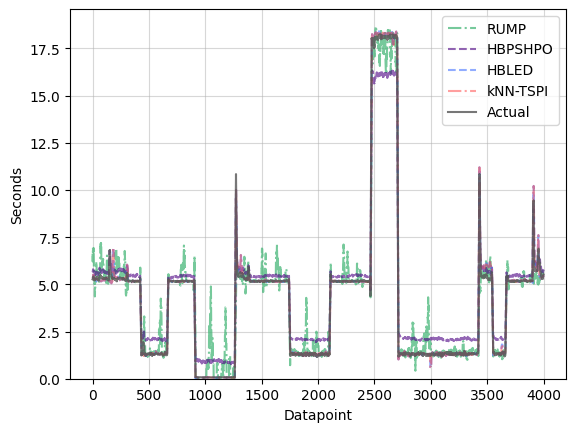

In [2]:
"""Get prediction figures"""

rpi_name = 'RPi4B8GB_1800' #RPi4B8GB_1800, RPi4B4GB_1500, RPi4B2GB2_1500, RPi4B2GB1_1200
data_seq = 'pattern' # random, pattern
data_num = '' # _2, _3, _4
methods = ['HBPSHPO', 'HSMM','kNN-TSPI','Encoder-Decoder']
methods_dict = {'HBPSHPO':{},'HSMM':{},'kNN-TSPI':{},'Encoder-Decoder':{}}
lookahead_list = [1]#,2,5,10,15,30,60]


for method in methods:
  for lookahead in lookahead_list:
    print(f"{method} figures for {rpi_name}_{data_seq}{data_num} for {lookahead} step")
    model_name = f'{rpi_name}_{data_seq}_{lookahead*5}sec'
    if method == 'HSMM':
      obs_dict = pd.read_csv(f"Results/{method}/{rpi_name.split('_')[0]}/predictions/HSMM_Results_rvp_{data_seq}_48hr{data_num}_1500sec_lb_{lookahead*5}sec_pw.csv")
    elif method == 'HBPSHPO':
      obs_dict = pd.read_csv(f"Results/{method}/{rpi_name.split('_')[0]}/predictions/HBPSHPO_Results_{model_name}.csv")
    elif method == 'kNN-TSPI' or method == 'HBLED':
      obs_dict = pd.read_csv(f"Results/{method}/{rpi_name.split('_')[0]}/predictions/{rpi_name.split('_')[0]}_{rpi_name.split('_')[1]}MHz_{data_seq}{data_num}_{lookahead}Step.csv")
      obs_dict = obs_dict.applymap(parse_float)
    
    methods_dict[method]['user_cpu_obs'], methods_dict[method]['user_cpu_pred_obs'] = [], []
    methods_dict[method]['system_cpu_obs'], methods_dict[method]['system_cpu_pred_obs'] = [], []
    methods_dict[method]['idle_cpu_obs'], methods_dict[method]['idle_cpu_pred_obs'] = [], []
    methods_dict[method]['ram_obs'], methods_dict[method]['ram_pred_obs'] = [], []
    

    if method == 'HSMM' or method == 'HBPSHPO':

        for i in range(0,len(obs_dict),lookahead):
        
            methods_dict[method]['user_cpu_obs'].extend(loads(obs_dict['cpu_user_time_diff_observations'][i]))
            methods_dict[method]['user_cpu_pred_obs'].extend(loads(obs_dict['cpu_user_time_diff_predicted_observations'][i]))
            methods_dict[method]['system_cpu_obs'].extend(loads(obs_dict['cpu_system_time_diff_observations'][i]))
            methods_dict[method]['system_cpu_pred_obs'].extend(loads(obs_dict['cpu_system_time_diff_predicted_observations'][i]))
            methods_dict[method]['idle_cpu_obs'].extend(loads(obs_dict['cpu_idle_time_diff_observations'][i]))
            methods_dict[method]['idle_cpu_pred_obs'].extend(loads(obs_dict['cpu_idle_time_diff_predicted_observations'][i]))
            methods_dict[method]['ram_obs'].extend(loads(obs_dict['memory_observations'][i]))
            methods_dict[method]['ram_pred_obs'].extend(loads(obs_dict['memory_predicted_observations'][i]))

    elif method == 'kNN-TSPI' or method == 'Encoder-Decoder':
       
        for i in range(0,len(obs_dict),lookahead):
            methods_dict[method]['user_cpu_obs'].append(obs_dict['cpu_user_time_diff_obs'][i])
            methods_dict[method]['user_cpu_pred_obs'].append(obs_dict['cpu_user_time_diff_preds'][i])
            methods_dict[method]['system_cpu_obs'].append(obs_dict['cpu_system_time_diff_obs'][i])
            methods_dict[method]['system_cpu_pred_obs'].append(obs_dict['cpu_system_time_diff_preds'][i])
            methods_dict[method]['idle_cpu_obs'].append(obs_dict['cpu_idle_time_diff_obs'][i])
            methods_dict[method]['idle_cpu_pred_obs'].append(obs_dict['cpu_idle_time_diff_preds'][i])
            methods_dict[method]['ram_obs'].append(obs_dict['memory_obs'][i])
            methods_dict[method]['ram_pred_obs'].append(obs_dict['memory_preds'][i])
       

# 'user_cpu_pred_obs', 'system_cpu_pred_obs', 'idle_cpu_pred_obs', 'ram_pred_obs'
# 'user_cpu_obs', 'system_cpu_obs', 'idle_cpu_obs', 'ram_obs'

shift1 = 300
shift2 =  - 1380
start = 4000
end = 8000
filter = 10 # 1, 25, 50, 100

# Convert the input data to a NumPy array with a float data type
input_data1 = np.array(methods_dict['HSMM']['user_cpu_obs'][start:end], dtype=float)
input_data2 = np.array(methods_dict['HSMM']['user_cpu_pred_obs'][start:end], dtype=float)
input_data3 = np.array(methods_dict['HBPSHPO']['user_cpu_pred_obs'][start+shift1:end+shift1], dtype=float)
input_data4 = np.array(methods_dict['kNN-TSPI']['user_cpu_pred_obs'][start+shift2:end+shift2], dtype=float)
input_data5 = np.array(methods_dict['Encoder-Decoder']['user_cpu_pred_obs'][start+shift2:end+shift2], dtype=float)

# Apply the uniform_filter1d function
plot_pred_obs(
    uniform_filter1d(input_data1, size=filter),
    uniform_filter1d(input_data2, size=filter),
    uniform_filter1d(input_data3, size=filter),
    uniform_filter1d(input_data4, size=filter),
    uniform_filter1d(input_data5, size=filter),
    'RUMP', 'HBPSHPO', 'kNN-TSPI', 'HBLED', 'CPU User Time', 'Seconds', data_seq + data_num, rpi_name.split('_')[0], filter
)

In [3]:
def mk_groups(data):
  try:
      newdata = data.items()
  except:
      return

  thisgroup = []
  groups = []
  for key, value in newdata:
      newgroups = mk_groups(value)
      if newgroups is None:
          thisgroup.append((key, value))
      else:
          thisgroup.append((key, len(newgroups[-1])))
          if groups:
              groups = [g + n for n, g in zip(newgroups, groups)]
          else:
              groups = newgroups
  return [thisgroup] + groups

def add_line(ax, xpos, ypos, plus, minus):
  line = plt.Line2D([xpos, xpos], [ypos + plus, ypos - minus],
                    transform=ax.transAxes, color='black')
  line.set_clip_on(False)
  ax.add_line(line)

def label_group_bar(ax, mae_data, rmse_data):
  
  mae_groups, rmse_groups = mk_groups(mae_data), mk_groups(rmse_data)
  mae_xy, rmse_xy = mae_groups.pop(), rmse_groups.pop()
  mae_x, mae_y = zip(*mae_xy)
  rmse_x, rmse_y = zip(*rmse_xy)
  mae_ly, rmse_ly = len(mae_y), len(rmse_y)
  mae_xticks, rmse_xticks = np.arange(1, mae_ly + 1), np.arange(1, mae_ly + 1)

  color_pair1 = ['#aaffc3', '#8B3A3A']  # color pair 1:  Mint, Apricot: #ffd8b1, Blueviolet: #8A2BE2
  color_pair2 = ['#458B74','#FF6A6A']  # color pair 2: Teal, Beige: #fffac8, Pink: #fabed4


  # define list of dark colors
  # https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
#   rmse_bars = ax.bar(rmse_xticks+0.17, [np.mean(r_y) for r_y in rmse_y],width=0.5, align='center', error_kw=dict(lw=4, capsize=8, capthick=3),alpha=0.95) #yerr= [np.std(r_y) for r_y in rmse_y]
  mae_bars = ax.bar(mae_xticks, [np.mean(m_y) for m_y in mae_y], width=0.8, align='center', error_kw=dict(lw=4, capsize=8, capthick=3),alpha=0.85) #yerr= [np.std(m_y) for m_y in mae_y], 
  
  import matplotlib as mpl
  mpl.rcParams['hatch.linewidth'] = 4.0

  hatches = ['','//']*26

  count = 0

  for i in range(len(mae_bars)):
    count += 1
    if count == 1 or count == 2:
        mae_bars[0].set(label = 'MAE  - RUMP')
        mae_bars[i].set(hatch=hatches[i], facecolor='#2E8B57') # edgecolor='black'
        # rmse_bars[0].set(label = 'RMSE  - RUMP')
        # rmse_bars[i].set(hatch=hatches[i], facecolor='#54FF9F')
       
    elif count == 3 or count == 4:
        mae_bars[2].set(label = 'MAE  - HBPSHPO')
        mae_bars[i].set(hatch=hatches[i],  facecolor='#4B0082')
        # rmse_bars[2].set(label = 'RMSE  - HBPSHPO')
        # rmse_bars[i].set(hatch=hatches[i], facecolor='#E066FF')
    elif count == 5 or count == 6:
        mae_bars[4].set(label = 'MAE  - kNN-TSPI')
        mae_bars[i].set(hatch=hatches[i],  facecolor='#4876FF')
        # rmse_bars[4].set(label = 'RMSE  - kNN-TSPI')
        # rmse_bars[i].set(hatch=hatches[i], facecolor='#87CEFA')
    else:
        mae_bars[6].set(label = 'MAE  - HBLED')
        mae_bars[i].set(hatch=hatches[i],  facecolor='#CD2626')
        # rmse_bars[6].set(label = 'RMSE  - HBLED')
        # rmse_bars[i].set(hatch=hatches[i], facecolor='#FF6347')
        if count == 8:
            count = 0

  ax.set_xticks(mae_xticks)
  ax.set_xticklabels(mae_x)
  ax.set_xlim(.5, mae_ly + .5)
  ax.yaxis.grid(True)

  scale = 1. / mae_ly
  for pos in range(mae_ly + 1):
      add_line(ax, pos * scale, -.05, 0.05, 0)
  ypos = - .03
  while mae_groups:
      group = mae_groups.pop()
      pos = 0
      for label, rpos in group:
          lxpos = (pos + .5 * rpos) * scale
          if 'step' in label:
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
          else:
            pass
            # ypos = -.24
            # ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes, rotation=77)
          add_line(ax, pos * scale, ypos, .05, 0)
          pos += rpos
      add_line(ax, pos * scale, ypos, .05, 0)
    #   add_line(ax, pos * scale, ypos, .08, .02)
      ypos -= .06

def remove_outliers(data, threshold=3):
    """
    Removes outliers from a DataFrame using the z-score method.

    Parameters:
        data (pd.DataFrame): DataFrame containing the data.
        threshold (float): The threshold for removing outliers. Defaults to 3.

    Returns:
        pd.DataFrame: DataFrame with the outliers removed.
    """
    z_scores = np.abs(stats.zscore(data))
    filtered_entries = (z_scores < threshold).all(axis=1)
    return data[filtered_entries]

MAE of User CPU Time


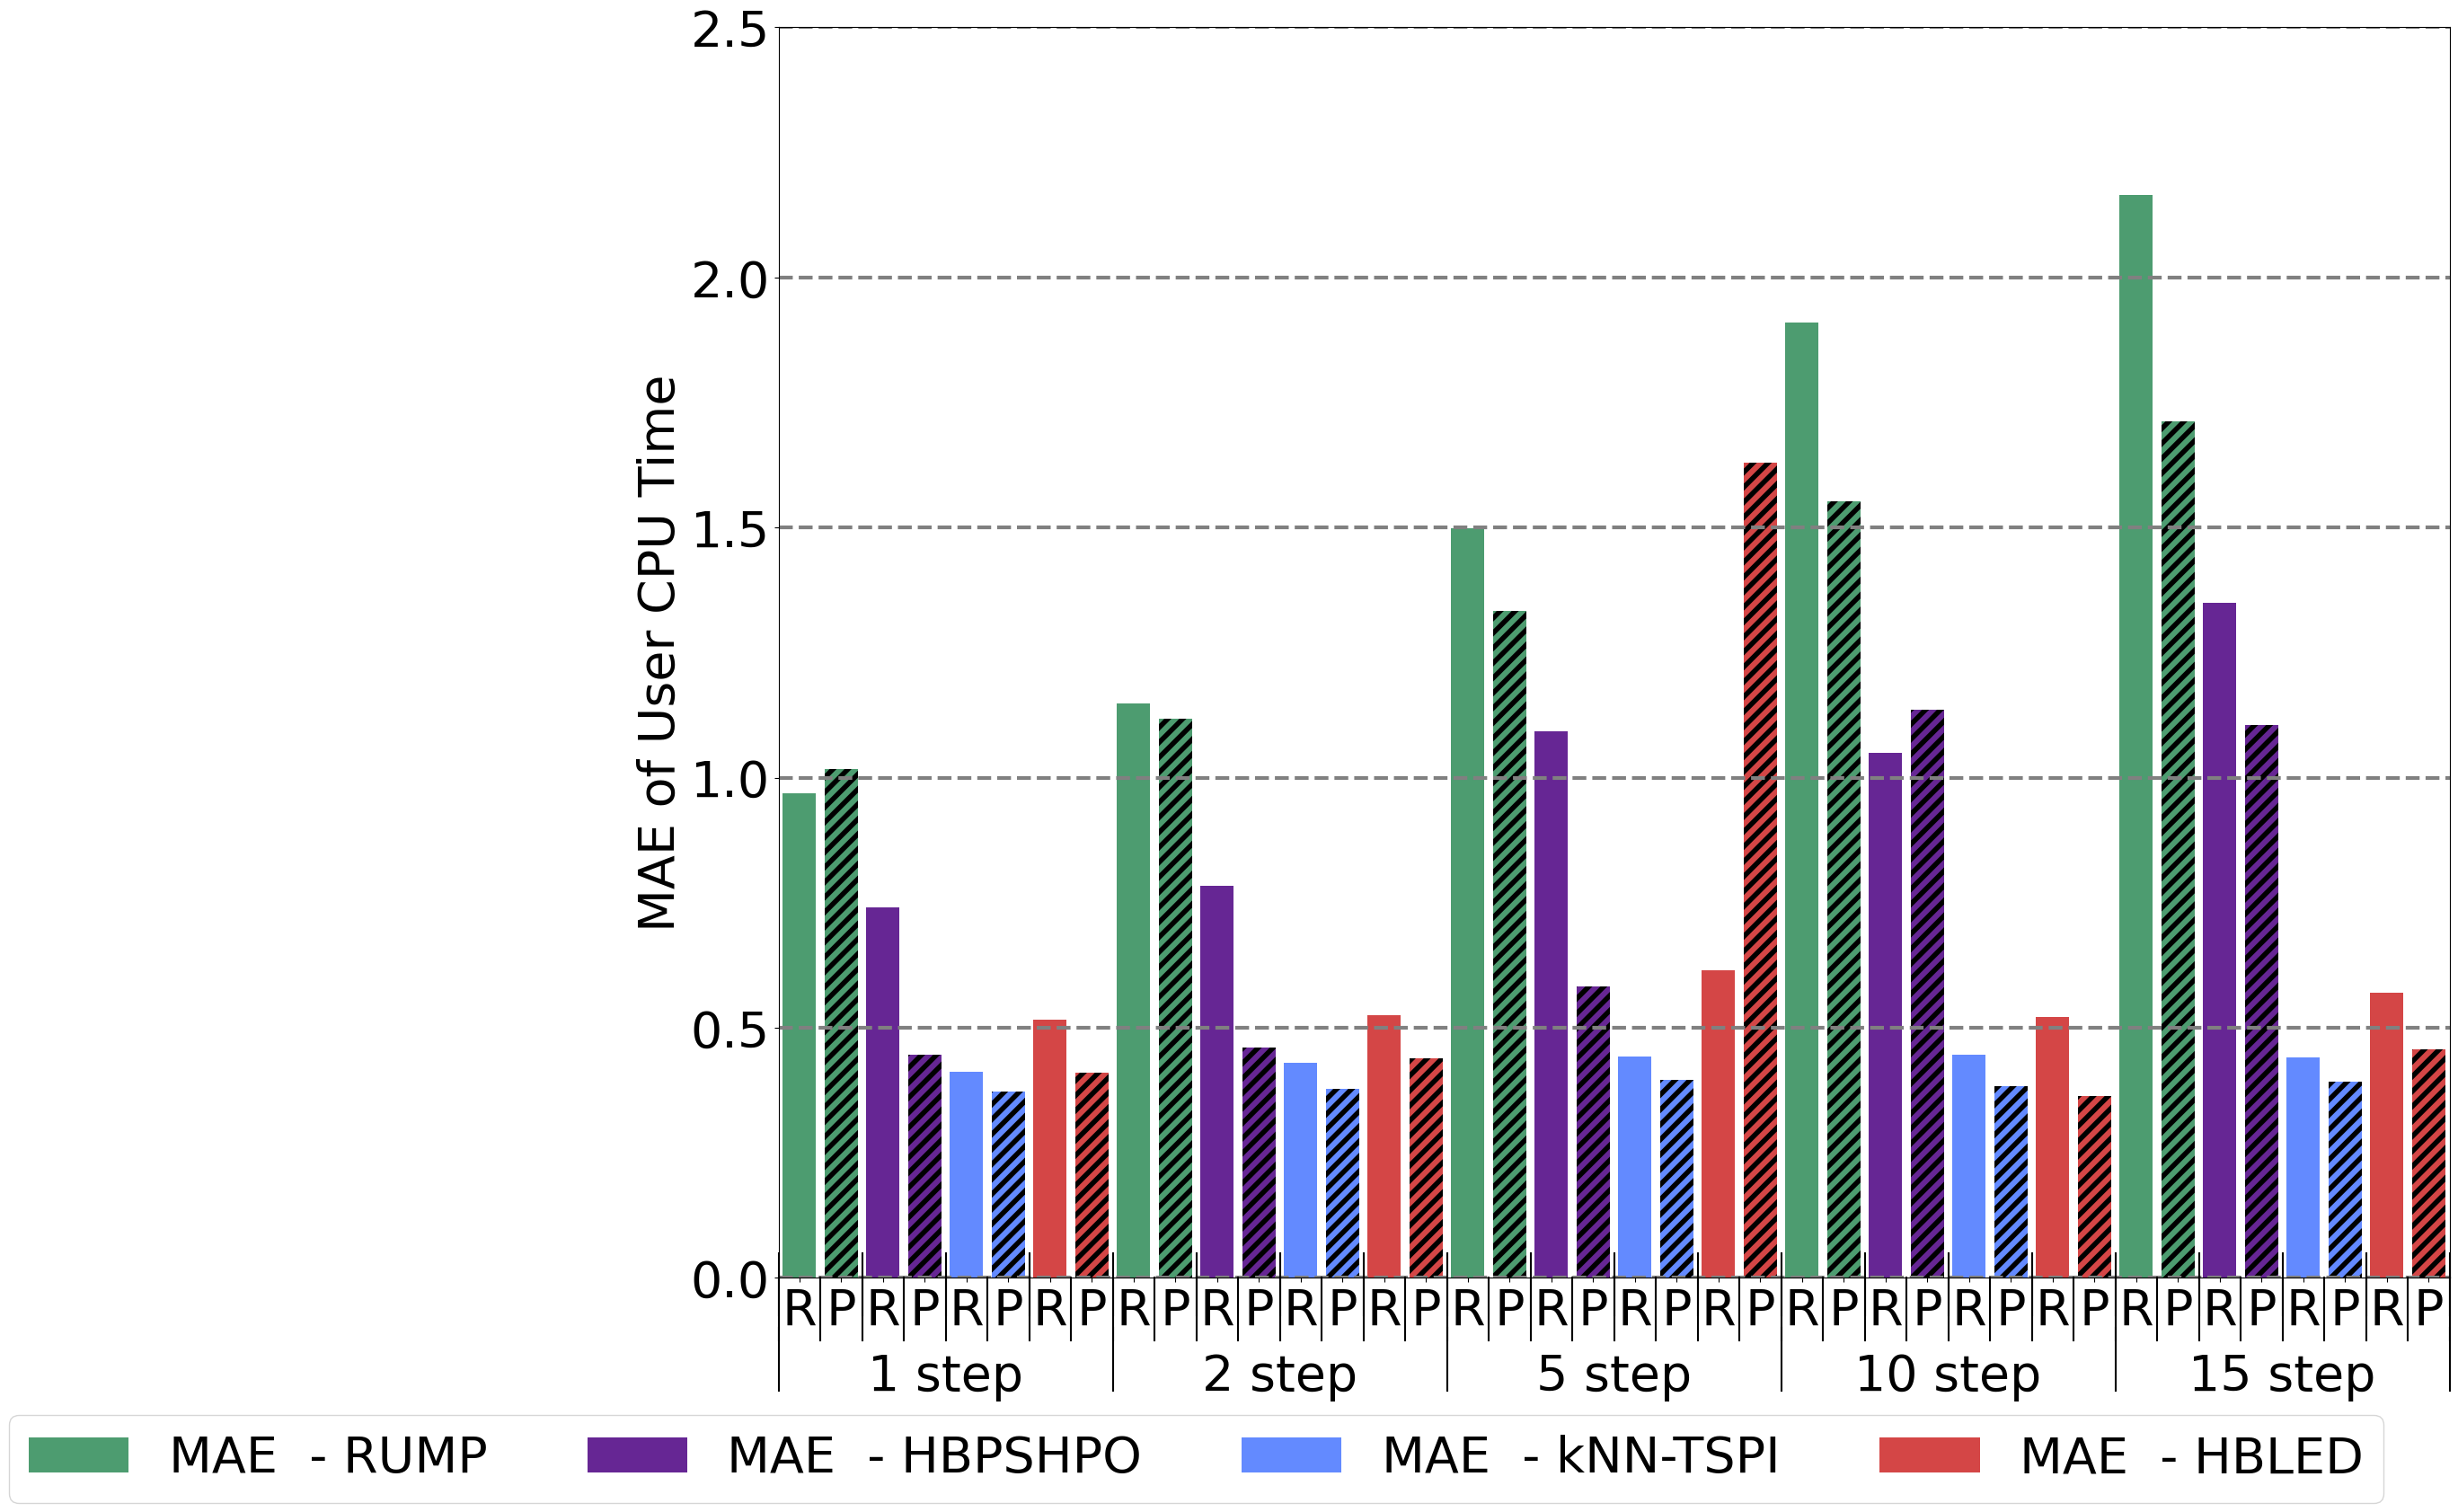

MAE of System CPU Time


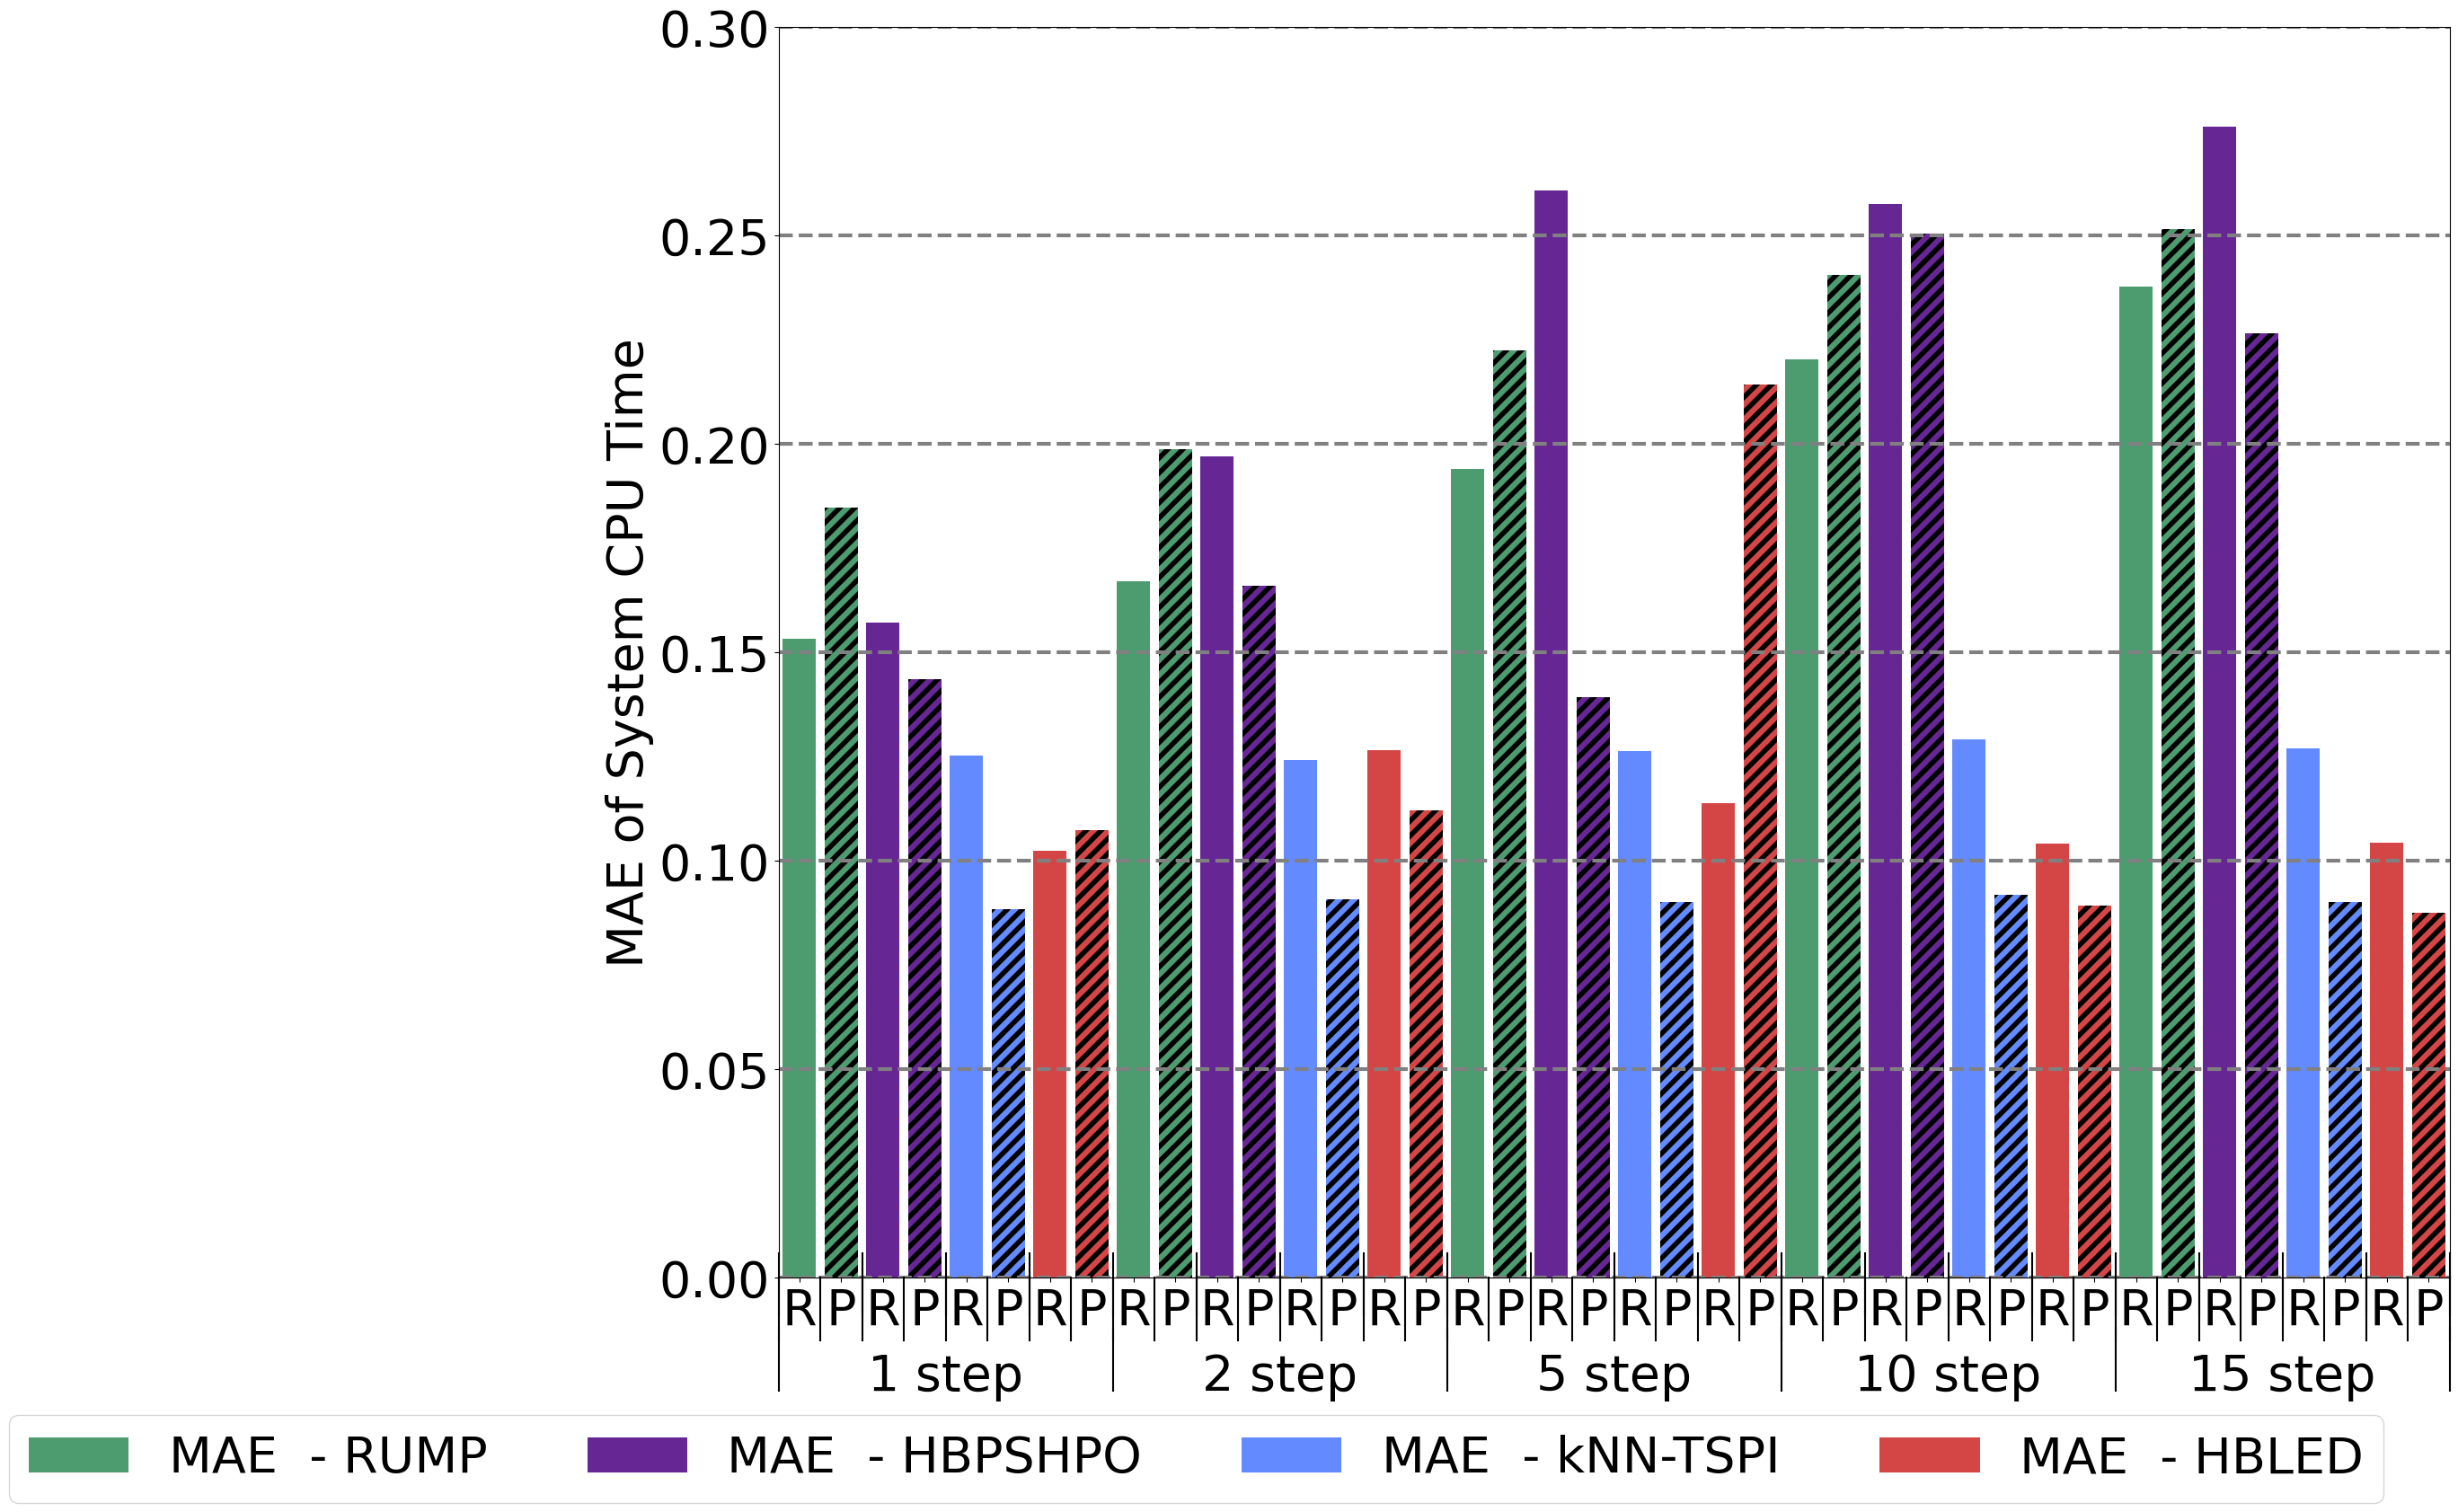

MAE of Idle CPU Time


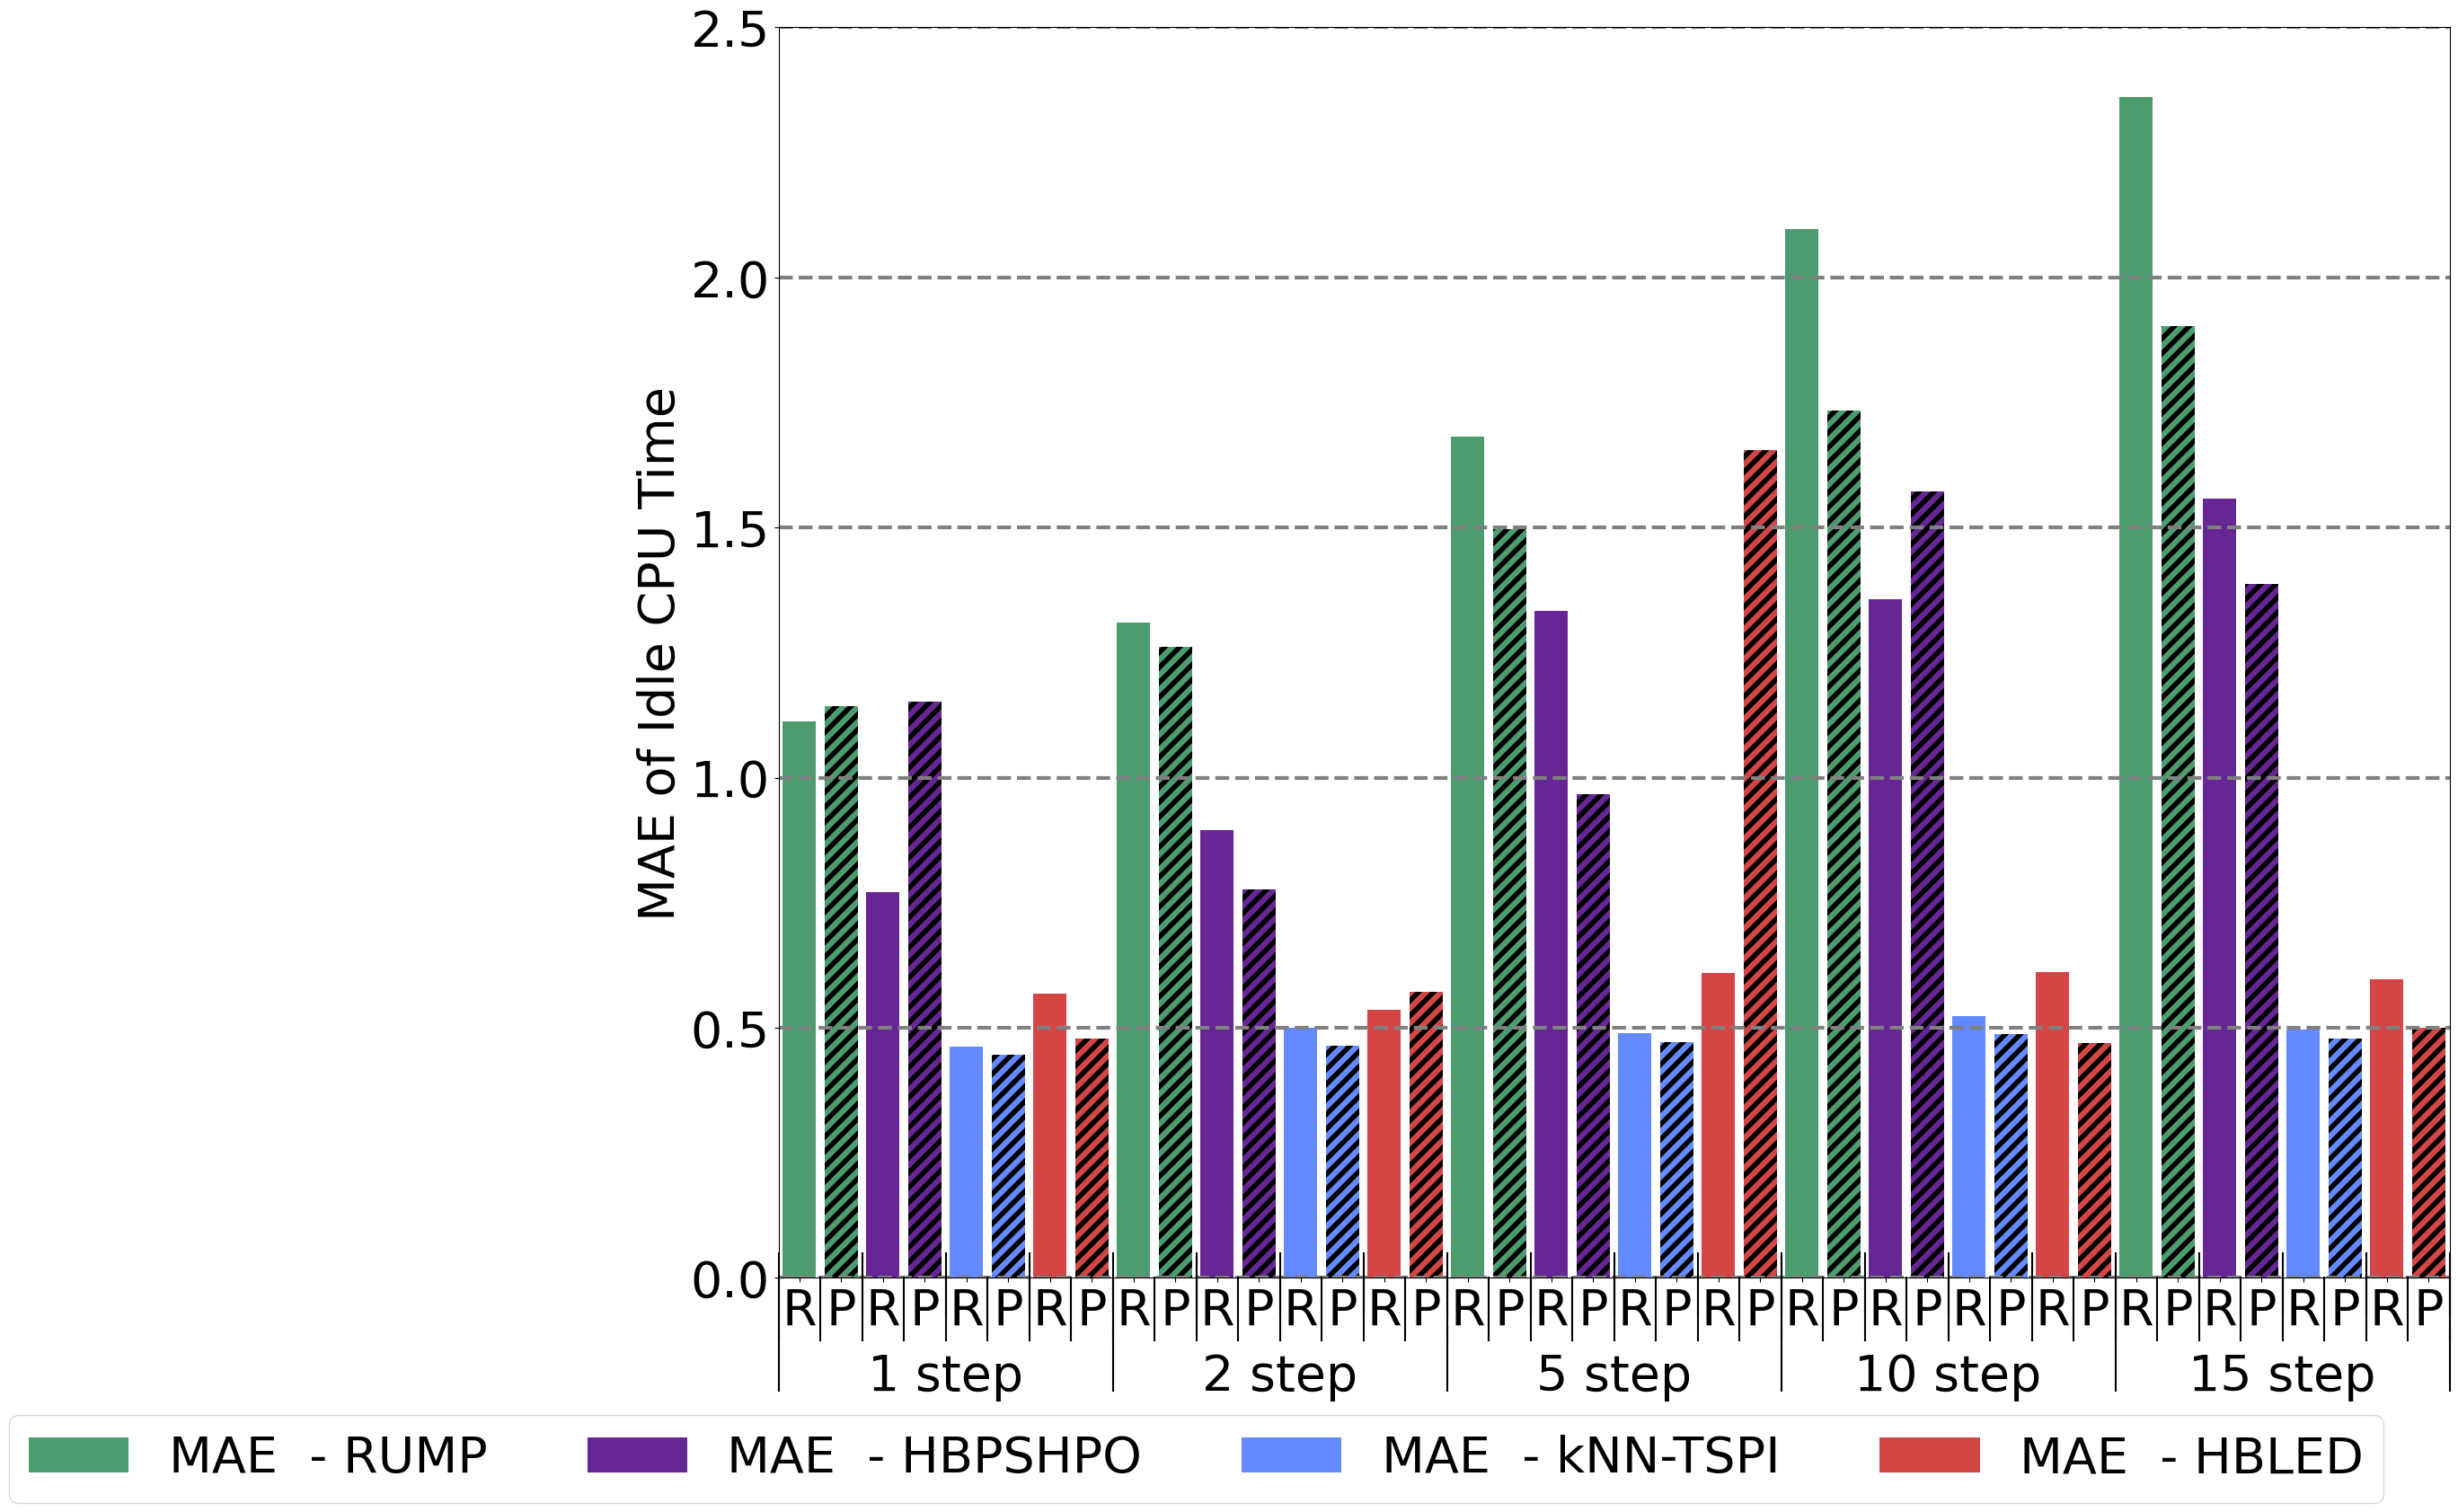

MAE of Memory Percent Usage


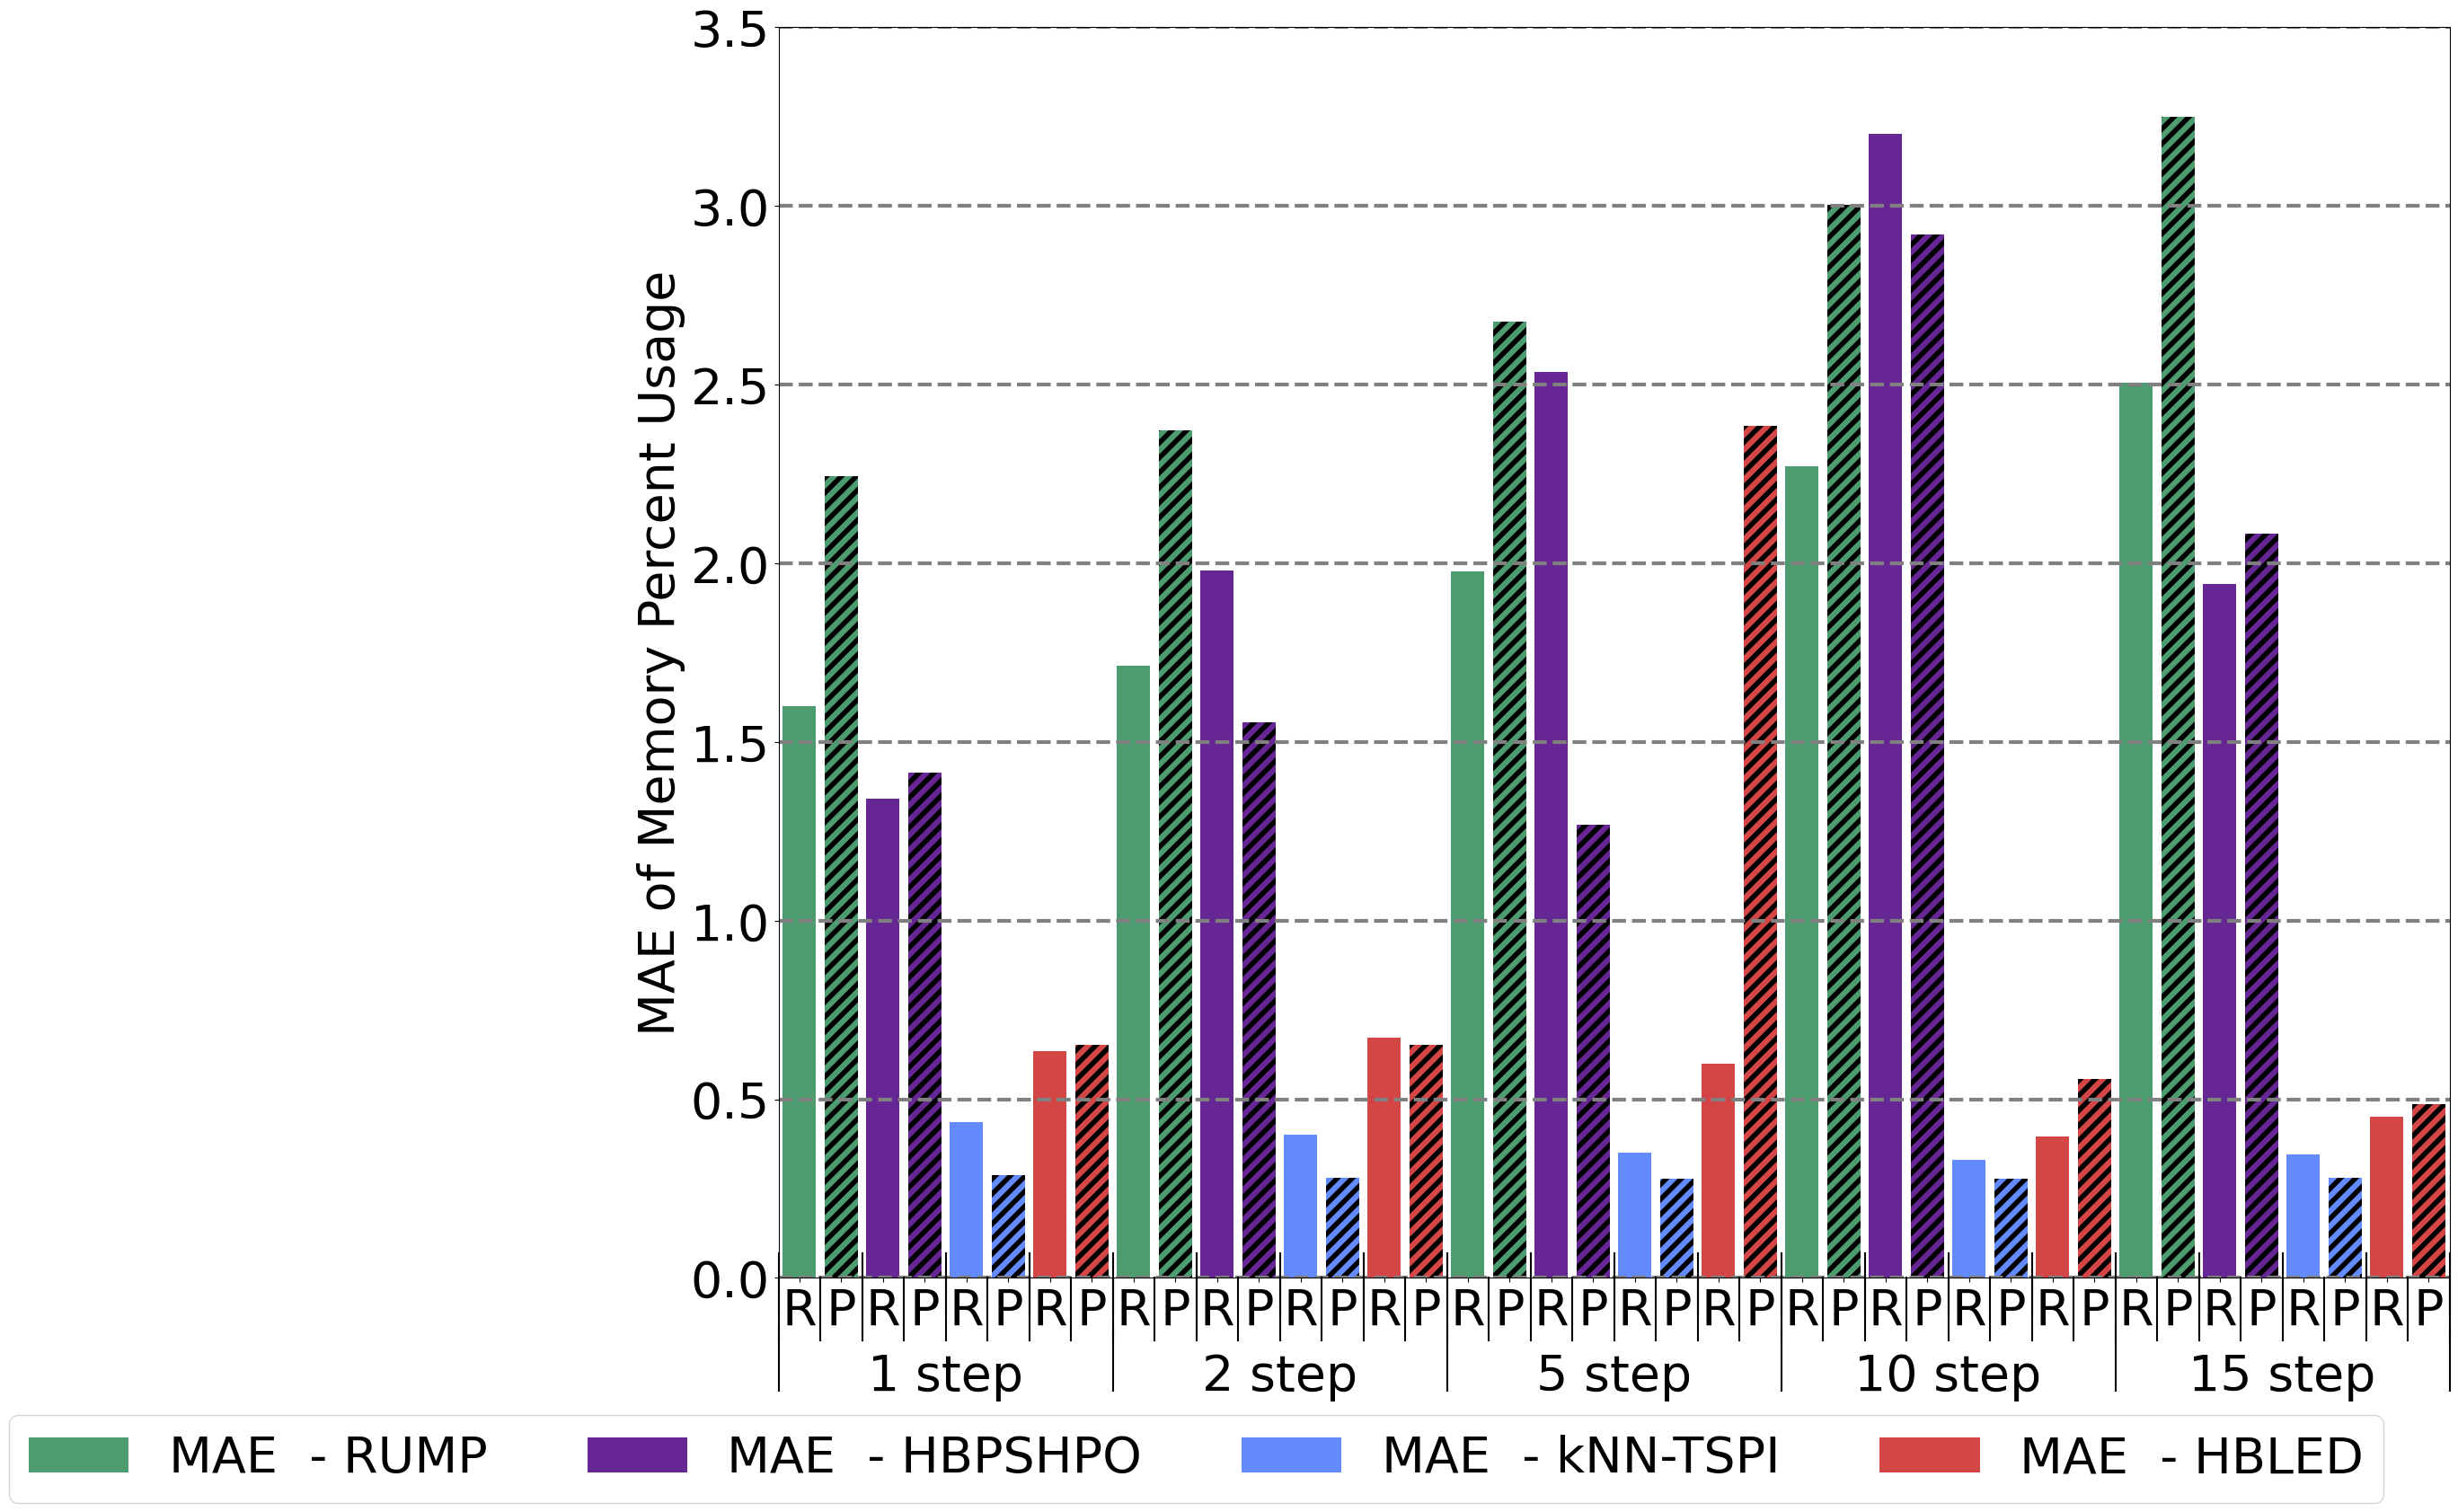

In [4]:
"""Get error figures"""
# rpi_name = 'RPi4B2GB1_1200' #RPi4B8GB_1800, RPi4B4GB_1500, RPi4B2GB2_1500, RPi4B2GB1_1200
rpi_name_list = ['RPi4B8GB_1800', 'RPi4B4GB_1500', 'RPi4B2GB1_1200', 'RPi4B2GB2_1500']
data_seq = 'random' # random, pattern
data_seq_list = ['random','pattern']
data_num = '' # _2, _3, _4

lookahead_list = [1,2,5,10,15]
HSMM_error_list, HBPSHPO_error_list = [], []


HSMM_columns = ['cpu_user_time_diff_mae','cpu_user_time_diff_rmse','cpu_system_time_diff_mae','cpu_system_time_diff_rmse','cpu_idle_time_diff_mae','cpu_idle_time_diff_rmse','memory_mae','memory_rmse']
HBPSHPO_columns = ['User CPU mae','User CPU rmse','System CPU mae','System CPU rmse','Idle CPU mae','Idle CPU rmse','RAM mae','RAM rmse']
#per_inst_columns = [cpu_user_time_diff_MAE	cpu_user_time_diff_RMSE	cpu_user_time_diff_MAPE	cpu_user_time_diff_SMAPE	
# cpu_system_time_diff_MAE	cpu_system_time_diff_RMSE	cpu_system_time_diff_MAPE	cpu_system_time_diff_SMAPE	
# cpu_idle_time_diff_MAE	cpu_idle_time_diff_RMSE	cpu_idle_time_diff_MAPE	cpu_idle_time_diff_SMAPE	
# memory_MAE	memory_RMSE	memory_MAPE	memory_SMAPE

Resources = {'MAE of User CPU Time':['cpu_user_time_diff_MAE','cpu_user_time_diff_RMSE','cpu_user_time_diff_mae','cpu_user_time_diff_rmse'],
             'MAE of System CPU Time':['cpu_system_time_diff_MAE','cpu_system_time_diff_RMSE','cpu_system_time_diff_mae','cpu_system_time_diff_rmse'],
             'MAE of Idle CPU Time':['cpu_idle_time_diff_MAE','cpu_idle_time_diff_RMSE','cpu_idle_time_diff_mae','cpu_idle_time_diff_rmse'],
             'MAE of Memory Percent Usage':['memory_MAE','memory_RMSE', 'memory_mae','memory_rmse']}

mae_data_dict_full, rmse_data_dict_full = {}, {}

for res in Resources:
  mae_data_dict, rmse_data_dict = {}, {}
  

  for lookahead in lookahead_list:

    mae_data_dict[f"{lookahead} step"] = {'RUMP': {'R':[],'P':[]}, 'HBPSHPO':{'R':[],'P':[]},'kNN-TSPI': {'R':[],'P':[]}, 'HBLED':{'R':[],'P':[]}}
    rmse_data_dict[f"{lookahead} step"] = {'RUMP': {'R':[],'P':[]}, 'HBPSHPO':{'R':[],'P':[]},'kNN-TSPI': {'R':[],'P':[]}, 'HBLED':{'R':[],'P':[]}}

    for rpi_name in rpi_name_list:

        for data_seq in data_seq_list:

            

            #print(f"Error figures for {rpi_name}_{data_seq}{data_num} for {lookahead} step")

            model_name = f'{rpi_name}_{data_seq}_{lookahead*5}sec'

            HSMM_temp = pd.read_csv(f"Results/HSMM/{rpi_name.split('_')[0]}/predictions/HSMM_Results_rvp_{data_seq}_48hr{data_num}_1500sec_lb_{lookahead*5}sec_pw.csv")
            HBPSHPO_temp = pd.read_csv(f"Results/HBPSHPO/{rpi_name.split('_')[0]}/predictions/HBPSHPO_Results_{model_name}.csv")
            kNN_TSPI_temp = pd.read_csv(f"Results/kNN-TSPI/{rpi_name.split('_')[0]}/metrics_per_inst/{rpi_name}MHz_{data_seq}_2_{lookahead}Step.csv")
            HBLED_temp = pd.read_csv(f"Results/Encoder-Decoder/{rpi_name.split('_')[0]}/metrics_per_inst/{rpi_name}MHz_{data_seq}_2_{lookahead}Step.csv")
            # kNN_TSPI_temp = remove_outliers(kNN_TSPI_temp)
            if data_seq == 'random':
                data_seq = 'R'
            elif data_seq == 'pattern':
                data_seq = 'P'

            mae_data_dict[f"{lookahead} step"]['RUMP'][data_seq].extend(HSMM_temp[Resources[res][2]])
            mae_data_dict[f"{lookahead} step"]['HBPSHPO'][data_seq].extend(HBPSHPO_temp[Resources[res][2]])
            mae_data_dict[f"{lookahead} step"]['kNN-TSPI'][data_seq].extend(kNN_TSPI_temp[Resources[res][0]])
            mae_data_dict[f"{lookahead} step"]['HBLED'][data_seq].extend(HBLED_temp[Resources[res][0]])

            rmse_data_dict[f"{lookahead} step"]['RUMP'][data_seq].extend(HSMM_temp[Resources[res][3]])
            rmse_data_dict[f"{lookahead} step"]['HBPSHPO'][data_seq].extend(HBPSHPO_temp[Resources[res][3]])
            rmse_data_dict[f"{lookahead} step"]['kNN-TSPI'][data_seq].extend(kNN_TSPI_temp[Resources[res][1]])
            rmse_data_dict[f"{lookahead} step"]['HBLED'][data_seq].extend(HBLED_temp[Resources[res][1]])


  plt.rcParams.update({'font.size': 40})  
  fig = plt.figure(figsize=(24,24))
  ax = fig.add_subplot(1,1,1)
  print(res)
  ax.set_ylabel(res)
  label_group_bar(ax, mae_data_dict, rmse_data_dict)
  plt.legend(loc='lower center', bbox_to_anchor=(0.25, -0.2),ncol=4)
  plt.grid(lw=3,ls='--', c='grey', axis='y')
  fig.subplots_adjust(bottom=0.3)
  
  if res == 'MAE of User CPU Time':
    plt.yticks(np.arange(0, 2.6, 0.5))
  elif res == 'MAE of System CPU Time':
    plt.yticks(np.arange(0, 0.31, 0.05))
  elif res == 'MAE of Idle CPU Time':
    plt.yticks(np.arange(0, 2.6, 0.5))
  elif res == 'MAE of Memory Percent Usage':
    plt.yticks(np.arange(0, 3.6, 0.5))
  fig.savefig(r"figures/{} Error Plot.png".format(res))
  plt.show()

  mae_data_dict_full[res] = mae_data_dict
  rmse_data_dict_full[res] = rmse_data_dict

In [28]:
# Calculate average percent difference for every model pair

per_lookahead_mean_mae_data, per_lookahead_stdv_mae_data = {}, {}
per_lookahead_pattern_mean_mae_data, per_lookahead_random_mean_mae_data = {}, {}
step_size_mean_mae_data, step_size_pattern_mean_mae_data, step_size_random_mean_mae_data = {}, {}, {}

for lookahead in [1, 2, 5, 10, 15]:
    per_model_mean_mae_data, per_model_stdv_mae_data = {}, {}
    per_model_random_mean_mae_data, per_model_pattern_mean_mae_data = {}, {}
    
    for model in ['HBPSHPO', 'kNN-TSPI', 'HBLED']:
        per_resource_mean_mae_data, per_resource_stdv_mae_data = {}, {}
        per_resource_random_mean_mae_data, per_resource_pattern_mean_mae_data = {}, {}
        
        resource_means, resource_patterns, resource_randoms = [], [], []
        
        for res in Resources:
            patt_mean = 100 * (np.mean(mae_data_dict[f'{lookahead} step']['RUMP']['P']) - np.mean(mae_data_dict[f'{lookahead} step'][model]['P'])) / np.mean(mae_data_dict[f'{lookahead} step']['RUMP']['P'])
            per_resource_pattern_mean_mae_data[res] = patt_mean
            resource_patterns.append(patt_mean)
            
            rand_mean = 100 * (np.mean(mae_data_dict[f'{lookahead} step']['RUMP']['R']) - np.mean(mae_data_dict[f'{lookahead} step'][model]['R'])) / np.mean(mae_data_dict[f'{lookahead} step']['RUMP']['R'])
            per_resource_random_mean_mae_data[res] = rand_mean
            resource_randoms.append(rand_mean)
            
            mean = (patt_mean + rand_mean) / 2
            per_resource_mean_mae_data[res] = mean
            resource_means.append(mean)
            
        per_model_pattern_mean_mae_data[model] = np.mean(list(per_resource_pattern_mean_mae_data.values()))
        per_model_random_mean_mae_data[model] = np.mean(list(per_resource_random_mean_mae_data.values()))
        per_model_mean_mae_data[model] = np.mean(list(per_resource_mean_mae_data.values()))

    per_lookahead_pattern_mean_mae_data[lookahead] = per_model_pattern_mean_mae_data
    per_lookahead_random_mean_mae_data[lookahead] = per_model_random_mean_mae_data
    per_lookahead_mean_mae_data[lookahead] = per_model_mean_mae_data

    # print()
    # print(f'Overall mean percent difference in MAE for {lookahead} step')
    # for model in per_model_mean_mae_data:
    #     print(f"Model {model}: Mean: {per_model_mean_mae_data[model]}")
    #     print(f"Model {model}: Max: {max(resource_means)}")
    #     print(f"Model {model}: Min: {min(resource_means)}")
    #     print('For Pattern')
    # for model in per_model_pattern_mean_mae_data:
    #     print(f"Model {model}: Mean: {per_model_pattern_mean_mae_data[model]}")
    #     print(f"Model {model}: Max: {max(resource_patterns)}")
    #     print(f"Model {model}: Min: {min(resource_patterns)}")
    # print('For Random')
    # for model in per_model_random_mean_mae_data:
    #     print(f"Model {model}: Mean: {per_model_random_mean_mae_data[model]}")
    #     print(f"Model {model}: Max: {max(resource_randoms)}")
    #     print(f"Model {model}: Min: {min(resource_randoms)}")
    # print()

    if model not in step_size_mean_mae_data:
        step_size_mean_mae_data[model] = []
    step_size_mean_mae_data[model].append(per_model_mean_mae_data[model])

    for model in per_model_pattern_mean_mae_data:
        if model not in step_size_pattern_mean_mae_data:
            step_size_pattern_mean_mae_data[model] = []
        step_size_pattern_mean_mae_data[model].append(per_model_pattern_mean_mae_data[model])

    for model in per_model_random_mean_mae_data:
        if model not in step_size_random_mean_mae_data:
            step_size_random_mean_mae_data[model] = []
        step_size_random_mean_mae_data[model].append(per_model_random_mean_mae_data[model])

print()
print("Averages for all step sizes:")
print("Mean MAE:")
for model in step_size_mean_mae_data:
    print(f"Model {model}: Mean: {np.mean(step_size_mean_mae_data[model])}")
    print(f"Model {model}: Max: {max(step_size_mean_mae_data[model])}")
    print(f"Model {model}: Min: {min(step_size_mean_mae_data[model])}")
print("Pattern Mean MAE:")
for model in step_size_pattern_mean_mae_data:
    print(f"Model {model}: Mean: {np.mean(step_size_pattern_mean_mae_data[model])}")
    print(f"Model {model}: Max: {max(step_size_pattern_mean_mae_data[model])}")
    print(f"Model {model}: Min: {min(step_size_pattern_mean_mae_data[model])}")

print("Random Mean MAE:")
for model in step_size_random_mean_mae_data:
    print(f"Model {model}: Mean: {np.mean(step_size_random_mean_mae_data[model])}")
    print(f"Model {model}: Max: {max(step_size_random_mean_mae_data[model])}")
    print(f"Model {model}: Min: {min(step_size_random_mean_mae_data[model])}")
print()


Averages for all step sizes:
Mean MAE:
Model HBLED: Mean: 67.62017673088025
Model HBLED: Max: 83.52094402809776
Model HBLED: Min: 40.263878906516695
Pattern Mean MAE:
Model HBPSHPO: Mean: 32.532695892985785
Model HBPSHPO: Max: 52.61042388671906
Model HBPSHPO: Min: 2.7095387074163053
Model kNN-TSPI: Mean: 89.41429514978144
Model kNN-TSPI: Max: 91.41070411419908
Model kNN-TSPI: Min: 87.14530280020413
Model HBLED: Mean: 64.15298319659202
Model HBLED: Max: 84.99824501045036
Model HBLED: Min: 10.885907973759855
Random Mean MAE:
Model HBPSHPO: Mean: -9.162594149993211
Model HBPSHPO: Max: 22.506576945161466
Model HBPSHPO: Min: -40.88258774314139
Model kNN-TSPI: Mean: 80.67217461100623
Model kNN-TSPI: Max: 86.21867150403288
Model kNN-TSPI: Min: 72.78881513083788
Model HBLED: Mean: 71.08737026516849
Model HBLED: Max: 82.58630795865861
Model HBLED: Min: 60.34378259323855



In [30]:
# Calculate average percent difference for every model pair

per_lookahead_mean_mae_data, per_lookahead_stdv_mae_data = {}, {}
per_lookahead_pattern_mean_mae_data, per_lookahead_random_mean_mae_data = {}, {}
step_size_mean_mae_data, step_size_pattern_mean_mae_data, step_size_random_mean_mae_data = {}, {}, {}

for lookahead in [1, 2, 5, 10, 15]:
    per_model_mean_mae_data, per_model_stdv_mae_data = {}, {}
    per_model_random_mean_mae_data, per_model_pattern_mean_mae_data = {}, {}
    
    for model in ['HBPSHPO', 'kNN-TSPI', 'HBLED']:
        per_resource_mean_mae_data, per_resource_stdv_mae_data = {}, {}
        per_resource_random_mean_mae_data, per_resource_pattern_mean_mae_data = {}, {}
        
        resource_means, resource_patterns, resource_randoms = [], [], []
        
        for res in Resources:
            patt_mean = 100 * (np.mean(mae_data_dict[f'{lookahead} step']['RUMP']['P']) - np.mean(mae_data_dict[f'{lookahead} step'][model]['P'])) / np.mean(mae_data_dict[f'{lookahead} step']['RUMP']['P'])
            per_resource_pattern_mean_mae_data[res] = patt_mean
            resource_patterns.append(patt_mean)
            
            rand_mean = 100 * (np.mean(mae_data_dict[f'{lookahead} step']['RUMP']['R']) - np.mean(mae_data_dict[f'{lookahead} step'][model]['R'])) / np.mean(mae_data_dict[f'{lookahead} step']['RUMP']['R'])
            per_resource_random_mean_mae_data[res] = rand_mean
            resource_randoms.append(rand_mean)
            
            mean = (patt_mean + rand_mean) / 2
            per_resource_mean_mae_data[res] = mean
            resource_means.append(mean)
            
        per_model_pattern_mean_mae_data[model] = np.mean(list(per_resource_pattern_mean_mae_data.values()))
        per_model_random_mean_mae_data[model] = np.mean(list(per_resource_random_mean_mae_data.values()))
        per_model_mean_mae_data[model] = np.mean(list(per_resource_mean_mae_data.values()))

    per_lookahead_pattern_mean_mae_data[lookahead] = per_model_pattern_mean_mae_data
    per_lookahead_random_mean_mae_data[lookahead] = per_model_random_mean_mae_data
    per_lookahead_mean_mae_data[lookahead] = per_model_mean_mae_data

    # print()
    # print(f'Overall mean percent difference in MAE for {lookahead} step')
    # for model in per_model_mean_mae_data:
    #     print(f"Model {model}: Mean: {per_model_mean_mae_data[model]}")
    #     print(f"Model {model}: Max: {max(resource_means)}")
    #     print(f"Model {model}: Min: {min(resource_means)}")
    #     print('For Pattern')
    # for model in per_model_pattern_mean_mae_data:
    #     print(f"Model {model}: Mean: {per_model_pattern_mean_mae_data[model]}")
    #     print(f"Model {model}: Max: {max(resource_patterns)}")
    #     print(f"Model {model}: Min: {min(resource_patterns)}")
    # print('For Random')
    # for model in per_model_random_mean_mae_data:
    #     print(f"Model {model}: Mean: {per_model_random_mean_mae_data[model]}")
    #     print(f"Model {model}: Max: {max(resource_randoms)}")
    #     print(f"Model {model}: Min: {min(resource_randoms)}")
    # print()

    if model not in step_size_mean_mae_data:
        step_size_mean_mae_data[model] = []
    step_size_mean_mae_data[model].append(per_model_mean_mae_data[model])

    for model in per_model_pattern_mean_mae_data:
        if model not in step_size_pattern_mean_mae_data:
            step_size_pattern_mean_mae_data[model] = []
        step_size_pattern_mean_mae_data[model].append(per_model_pattern_mean_mae_data[model])

    for model in per_model_random_mean_mae_data:
        if model not in step_size_random_mean_mae_data:
            step_size_random_mean_mae_data[model] = []
        step_size_random_mean_mae_data[model].append(per_model_random_mean_mae_data[model])

print()
print("Averages for all step sizes:")
print("Mean MAE:")
for model in step_size_mean_mae_data:
    print(f"Model {model}: Mean: {np.mean(step_size_mean_mae_data[model])}")
    print(f"Model {model}: Max: {max(step_size_mean_mae_data[model])}")
    print(f"Model {model}: Min: {min(step_size_mean_mae_data[model])}")
print("Pattern Mean MAE:")
for model in step_size_pattern_mean_mae_data:
    print(f"Model {model}: Mean: {np.mean(step_size_pattern_mean_mae_data[model])}")
    print(f"Model {model}: Max: {max(step_size_pattern_mean_mae_data[model])}")
    print(f"Model {model}: Min: {min(step_size_pattern_mean_mae_data[model])}")

print("Random Mean MAE:")
for model in step_size_random_mean_mae_data:
    print(f"Model {model}: Mean: {np.mean(step_size_random_mean_mae_data[model])}")
    print(f"Model {model}: Max: {max(step_size_random_mean_mae_data[model])}")
    print(f"Model {model}: Min: {min(step_size_random_mean_mae_data[model])}")
print()


Averages for all step sizes:
Mean MAE:
Model HBLED: Mean: 67.62017673088025
Model HBLED: Max: 83.52094402809776
Model HBLED: Min: 40.263878906516695
Pattern Mean MAE:
Model HBPSHPO: Mean: 32.532695892985785
Model HBPSHPO: Max: 52.61042388671906
Model HBPSHPO: Min: 2.7095387074163053
Model kNN-TSPI: Mean: 89.41429514978144
Model kNN-TSPI: Max: 91.41070411419908
Model kNN-TSPI: Min: 87.14530280020413
Model HBLED: Mean: 64.15298319659202
Model HBLED: Max: 84.99824501045036
Model HBLED: Min: 10.885907973759855
Random Mean MAE:
Model HBPSHPO: Mean: -9.162594149993211
Model HBPSHPO: Max: 22.506576945161466
Model HBPSHPO: Min: -40.88258774314139
Model kNN-TSPI: Mean: 80.67217461100623
Model kNN-TSPI: Max: 86.21867150403288
Model kNN-TSPI: Min: 72.78881513083788
Model HBLED: Mean: 71.08737026516849
Model HBLED: Max: 82.58630795865861
Model HBLED: Min: 60.34378259323855



In [58]:
"""Get error figures"""
# rpi_name = 'RPi4B2GB1_1200' #RPi4B8GB_1800, RPi4B4GB_1500, RPi4B2GB2_1500, RPi4B2GB1_1200
rpi_name_list = ['RPi4B8GB_1800', 'RPi4B4GB_1500', 'RPi4B2GB1_1200', 'RPi4B2GB2_1500']
data_seq = 'random' # random, pattern
data_seq_list = ['random','pattern']
data_num = '' # _2, _3, _4

lookahead_list = [1,2,5,10,15]
HSMM_error_list, HBPSHPO_error_list = [], []


HSMM_columns = ['cpu_user_time_diff_mae','cpu_user_time_diff_rmse','cpu_system_time_diff_mae','cpu_system_time_diff_rmse','cpu_idle_time_diff_mae','cpu_idle_time_diff_rmse','memory_mae','memory_rmse']
HBPSHPO_columns = ['User CPU mae','User CPU rmse','System CPU mae','System CPU rmse','Idle CPU mae','Idle CPU rmse','RAM mae','RAM rmse']
#per_inst_columns = [cpu_user_time_diff_MAE	cpu_user_time_diff_RMSE	cpu_user_time_diff_MAPE	cpu_user_time_diff_SMAPE	
# cpu_system_time_diff_MAE	cpu_system_time_diff_RMSE	cpu_system_time_diff_MAPE	cpu_system_time_diff_SMAPE	
# cpu_idle_time_diff_MAE	cpu_idle_time_diff_RMSE	cpu_idle_time_diff_MAPE	cpu_idle_time_diff_SMAPE	
# memory_MAE	memory_RMSE	memory_MAPE	memory_SMAPE

Resources = {'MAE of User CPU Time':['cpu_user_time_diff_MAE','cpu_user_time_diff_RMSE','cpu_user_time_diff_mae','cpu_user_time_diff_rmse'],
             'MAE of System CPU Time':['cpu_system_time_diff_MAE','cpu_system_time_diff_RMSE','cpu_system_time_diff_mae','cpu_system_time_diff_rmse'],
             'MAE of Idle CPU Time':['cpu_idle_time_diff_MAE','cpu_idle_time_diff_RMSE','cpu_idle_time_diff_mae','cpu_idle_time_diff_rmse'],
             'MAE of Memory Percent Usage':['memory_MAE','memory_RMSE', 'memory_mae','memory_rmse']}

mae_data_dict_full, rmse_data_dict_full = {}, {}

for res in Resources:
  mae_data_dict, rmse_data_dict = {}, {}
  

  for lookahead in lookahead_list:

    mae_data_dict[f"{lookahead} step"] = {'RUMP': {'R':[],'P':[]}, 'HBPSHPO':{'R':[],'P':[]},'kNN-TSPI': {'R':[],'P':[]}, 'HBLED':{'R':[],'P':[]}}
    rmse_data_dict[f"{lookahead} step"] = {'RUMP': {'R':[],'P':[]}, 'HBPSHPO':{'R':[],'P':[]},'kNN-TSPI': {'R':[],'P':[]}, 'HBLED':{'R':[],'P':[]}}

    for rpi_name in rpi_name_list:

        for data_seq in data_seq_list:

            

            #print(f"Error figures for {rpi_name}_{data_seq}{data_num} for {lookahead} step")

            model_name = f'{rpi_name}_{data_seq}_{lookahead*5}sec'

            HSMM_temp = pd.read_csv(f"Results/HSMM/{rpi_name.split('_')[0]}/predictions/HSMM_Results_rvp_{data_seq}_48hr{data_num}_1500sec_lb_{lookahead*5}sec_pw.csv")
            HBPSHPO_temp = pd.read_csv(f"Results/HBPSHPO/{rpi_name.split('_')[0]}/predictions/HBPSHPO_Results_{model_name}.csv")
            kNN_TSPI_temp = pd.read_csv(f"Results/kNN-TSPI/{rpi_name.split('_')[0]}/metrics_per_inst/{rpi_name}MHz_{data_seq}_2_{lookahead}Step.csv")
            HBLED_temp = pd.read_csv(f"Results/Encoder-Decoder/{rpi_name.split('_')[0]}/metrics_per_inst/{rpi_name}MHz_{data_seq}_2_{lookahead}Step.csv")
            # kNN_TSPI_temp = remove_outliers(kNN_TSPI_temp)
            if data_seq == 'random':
                data_seq = 'R'
            elif data_seq == 'pattern':
                data_seq = 'P'

            mae_data_dict[f"{lookahead} step"]['RUMP'][data_seq].extend(HSMM_temp[Resources[res][2]])
            mae_data_dict[f"{lookahead} step"]['HBPSHPO'][data_seq].extend(HBPSHPO_temp[Resources[res][2]])
            mae_data_dict[f"{lookahead} step"]['kNN-TSPI'][data_seq].extend(kNN_TSPI_temp[Resources[res][0]])
            mae_data_dict[f"{lookahead} step"]['HBLED'][data_seq].extend(HBLED_temp[Resources[res][0]])

            rmse_data_dict[f"{lookahead} step"]['RUMP'][data_seq].extend(HSMM_temp[Resources[res][3]])
            rmse_data_dict[f"{lookahead} step"]['HBPSHPO'][data_seq].extend(HBPSHPO_temp[Resources[res][3]])
            rmse_data_dict[f"{lookahead} step"]['kNN-TSPI'][data_seq].extend(kNN_TSPI_temp[Resources[res][1]])
            rmse_data_dict[f"{lookahead} step"]['HBLED'][data_seq].extend(HBLED_temp[Resources[res][1]])


#   plt.rcParams.update({'font.size': 40})  
#   fig = plt.figure(figsize=(24,24))
#   ax = fig.add_subplot(1,1,1)
  print(res)
#   ax.set_ylabel(res)
#   label_group_bar(ax, mae_data_dict, rmse_data_dict)
#   plt.legend(loc='lower center', bbox_to_anchor=(0.25, -0.2),ncol=4)
#   plt.grid(lw=3,ls='--', c='grey', axis='y')
#   fig.subplots_adjust(bottom=0.3)
  
#   if res == 'MAE of User CPU Time':
#     plt.yticks(np.arange(0, 2.6, 0.5))
#   elif res == 'MAE of System CPU Time':
#     plt.yticks(np.arange(0, 0.31, 0.05))
#   elif res == 'MAE of Idle CPU Time':
#     plt.yticks(np.arange(0, 2.6, 0.5))
#   elif res == 'MAE of Memory Percent Usage':
#     plt.yticks(np.arange(0, 3.6, 0.5))
# #   fig.savefig(r"figures/{} Error Plot.png".format(res))
#   plt.show()

  mae_data_dict_full[res] = mae_data_dict
  rmse_data_dict_full[res] = rmse_data_dict

  for step_size in ['1 step', '2 step', '5 step', '10 step', '15 step']:
    print(f"\n{step_size}:")
    for category in ['R', 'P']:
        print(f"\n{category}:")
        rump_data = mae_data_dict[step_size]['RUMP'][category]

        for model in ['HBLED', 'kNN-TSPI', 'HBPSHPO']:
            model_data = mae_data_dict[step_size][model][category]

            mean_diff = 100 * ((sum(rump_data) - sum(model_data)) / sum(rump_data))
 
            print(f"{model}: Mean: {mean_diff}")

MAE of User CPU Time

1 step:

R:
HBLED: Mean: 61.68107467551306
kNN-TSPI: Mean: 70.63699235691031
HBPSHPO: Mean: 22.23455449220145

P:
HBLED: Mean: 70.94190456284127
kNN-TSPI: Mean: 74.7229781863099
HBPSHPO: Mean: 56.41319893221392

2 step:

R:
HBLED: Mean: 67.09329209812837
kNN-TSPI: Mean: 74.18134693497083
HBPSHPO: Mean: 30.524403763904722

P:
HBLED: Mean: 71.72301968034404
kNN-TSPI: Mean: 76.6241828346984
HBPSHPO: Mean: 59.094166376488964

5 step:

R:
HBLED: Mean: 70.46333220240838
kNN-TSPI: Mean: 79.57683380752611
HBPSHPO: Mean: 25.833280062634994

P:
HBLED: Mean: 12.068737599308857
kNN-TSPI: Mean: 79.46358667724655
HBPSHPO: Mean: 56.61051069207762

10 step:

R:
HBLED: Mean: 80.34351831989977
kNN-TSPI: Mean: 83.87757889255958
HBPSHPO: Mean: 44.099731564325246

P:
HBLED: Mean: 83.15218128893198
kNN-TSPI: Mean: 82.91511973567549
HBPSHPO: Mean: 27.43442045783392

15 step:

R:
HBLED: Mean: 81.08209078512539
kNN-TSPI: Mean: 85.95359633259982
HBPSHPO: Mean: 36.63073303499212

P:
HBLED: 

HBPSHPO figures for RPi4B8GB_1800_pattern for 1 step
HSMM figures for RPi4B8GB_1800_pattern for 1 step
kNN-TSPI figures for RPi4B8GB_1800_pattern for 1 step
Encoder-Decoder figures for RPi4B8GB_1800_pattern for 1 step
CPU User Time


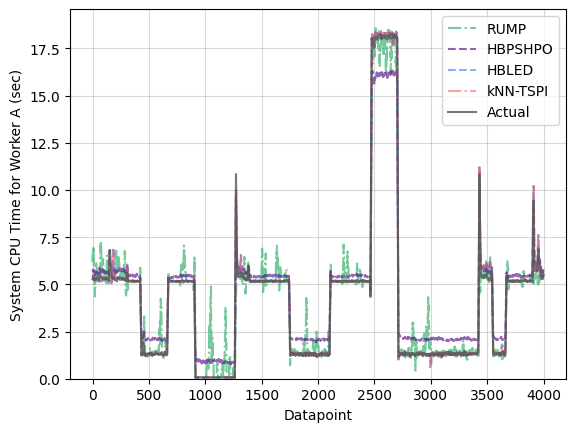

In [3]:
"""Get prediction figures"""

rpi_name = 'RPi4B8GB_1800' #RPi4B8GB_1800, RPi4B4GB_1500, RPi4B2GB2_1500, RPi4B2GB1_1200
data_seq = 'pattern' # random, pattern
data_num = '' # _2, _3, _4
methods = ['HBPSHPO', 'HSMM','kNN-TSPI','Encoder-Decoder']
methods_dict = {'HBPSHPO':{},'HSMM':{},'kNN-TSPI':{},'Encoder-Decoder':{}}
lookahead_list = [1]#,2,5,10,15,30,60]


for method in methods:
  for lookahead in lookahead_list:
    print(f"{method} figures for {rpi_name}_{data_seq}{data_num} for {lookahead} step")
    model_name = f'{rpi_name}_{data_seq}_{lookahead*5}sec'
    if method == 'HSMM':
      obs_dict = pd.read_csv(f"Results/{method}/{rpi_name.split('_')[0]}/predictions/HSMM_Results_rvp_{data_seq}_48hr{data_num}_1500sec_lb_{lookahead*5}sec_pw.csv")
    elif method == 'HBPSHPO':
      obs_dict = pd.read_csv(f"Results/{method}/{rpi_name.split('_')[0]}/predictions/HBPSHPO_Results_{model_name}.csv")
    elif method == 'kNN-TSPI' or method == 'HBLED':
      obs_dict = pd.read_csv(f"Results/{method}/{rpi_name.split('_')[0]}/predictions/{rpi_name.split('_')[0]}_{rpi_name.split('_')[1]}MHz_{data_seq}{data_num}_{lookahead}Step.csv")
      obs_dict = obs_dict.applymap(parse_float)
    
    methods_dict[method]['user_cpu_obs'], methods_dict[method]['user_cpu_pred_obs'] = [], []
    methods_dict[method]['system_cpu_obs'], methods_dict[method]['system_cpu_pred_obs'] = [], []
    methods_dict[method]['idle_cpu_obs'], methods_dict[method]['idle_cpu_pred_obs'] = [], []
    methods_dict[method]['ram_obs'], methods_dict[method]['ram_pred_obs'] = [], []
    

    if method == 'HSMM' or method == 'HBPSHPO':

        for i in range(0,len(obs_dict),lookahead):
        
            methods_dict[method]['user_cpu_obs'].extend(loads(obs_dict['cpu_user_time_diff_observations'][i]))
            methods_dict[method]['user_cpu_pred_obs'].extend(loads(obs_dict['cpu_user_time_diff_predicted_observations'][i]))
            methods_dict[method]['system_cpu_obs'].extend(loads(obs_dict['cpu_system_time_diff_observations'][i]))
            methods_dict[method]['system_cpu_pred_obs'].extend(loads(obs_dict['cpu_system_time_diff_predicted_observations'][i]))
            methods_dict[method]['idle_cpu_obs'].extend(loads(obs_dict['cpu_idle_time_diff_observations'][i]))
            methods_dict[method]['idle_cpu_pred_obs'].extend(loads(obs_dict['cpu_idle_time_diff_predicted_observations'][i]))
            methods_dict[method]['ram_obs'].extend(loads(obs_dict['memory_observations'][i]))
            methods_dict[method]['ram_pred_obs'].extend(loads(obs_dict['memory_predicted_observations'][i]))

    elif method == 'kNN-TSPI' or method == 'Encoder-Decoder':
       
        for i in range(0,len(obs_dict),lookahead):
            methods_dict[method]['user_cpu_obs'].append(obs_dict['cpu_user_time_diff_obs'][i])
            methods_dict[method]['user_cpu_pred_obs'].append(obs_dict['cpu_user_time_diff_preds'][i])
            methods_dict[method]['system_cpu_obs'].append(obs_dict['cpu_system_time_diff_obs'][i])
            methods_dict[method]['system_cpu_pred_obs'].append(obs_dict['cpu_system_time_diff_preds'][i])
            methods_dict[method]['idle_cpu_obs'].append(obs_dict['cpu_idle_time_diff_obs'][i])
            methods_dict[method]['idle_cpu_pred_obs'].append(obs_dict['cpu_idle_time_diff_preds'][i])
            methods_dict[method]['ram_obs'].append(obs_dict['memory_obs'][i])
            methods_dict[method]['ram_pred_obs'].append(obs_dict['memory_preds'][i])
       

# 'user_cpu_pred_obs', 'system_cpu_pred_obs', 'idle_cpu_pred_obs', 'ram_pred_obs'
# 'user_cpu_obs', 'system_cpu_obs', 'idle_cpu_obs', 'ram_obs'

shift1 = 300
shift2 =  - 1380
start = 4000
end = 8000
filter = 10 # 1, 25, 50, 100

# Convert the input data to a NumPy array with a float data type
input_data1 = np.array(methods_dict['HSMM']['user_cpu_obs'][start:end], dtype=float)
input_data2 = np.array(methods_dict['HSMM']['user_cpu_pred_obs'][start:end], dtype=float)
input_data3 = np.array(methods_dict['HBPSHPO']['user_cpu_pred_obs'][start+shift1:end+shift1], dtype=float)
input_data4 = np.array(methods_dict['kNN-TSPI']['user_cpu_pred_obs'][start+shift2:end+shift2], dtype=float)
input_data5 = np.array(methods_dict['Encoder-Decoder']['user_cpu_pred_obs'][start+shift2:end+shift2], dtype=float)

# Apply the uniform_filter1d function
plot_pred_obs(
    uniform_filter1d(input_data1, size=filter),
    uniform_filter1d(input_data2, size=filter),
    uniform_filter1d(input_data3, size=filter),
    uniform_filter1d(input_data4, size=filter),
    uniform_filter1d(input_data5, size=filter),
    'RUMP', 'HBPSHPO', 'kNN-TSPI', 'HBLED', 'CPU User Time', 'System CPU Time for Worker A (sec)', data_seq + data_num, rpi_name.split('_')[0], filter
)